In [1]:
from collections import Counter
import re

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif

import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')
spw_set = set(stopwords.words('english'))
spw_set.add('url')
tokenizer = TweetTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xiaolei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
all_data = pd.read_csv('../data/dataset.tsv', sep='\t', dtype=str)
all_data.tid = all_data.tid.apply(lambda x: str(x))
all_data = all_data[~all_data.text.isna()]
all_data = all_data[~all_data.labels.isna()]
print(len(all_data))
all_data.head()

31849


,tid,text,corpus,labels
0,521033092132503552,@fergusonoctober @fox2now #alllivesmatter peac...,ALM,"care,purity"
1,537681598989475841,wholeheartedly support these protests acts of ...,ALM,"subversion,loyalty"
2,624644420705648640,this sandra bland situation man no disrespect ...,ALM,cheating
3,752979765984890884,"commitment to peace, healing and loving neighb...",ALM,"care,purity"
4,548029362348765185,injustice for one is an injustice for all #all...,ALM,"cheating,loyalty"


In [3]:
# preprocessing url
def preprocess(tweet):
    """
    Preprocess a single tweet
    :param tweet:
    :return:
    """
    global tokenizer

    # lowercase
    tweet = tweet.lower()
    # replace url
    tweet = re.sub(r"https?:\S+", "URL", tweet)
    # replace user
#     tweet = re.sub(r'@\w+', 'USER', tweet)
    # replace hashtag
#     tweet = re.sub(r'#\S+', 'HASHTAG', tweet)
    # tokenize
    return [item.strip() for item in tokenizer.tokenize(tweet) if len(item.strip())>0]

In [4]:
# preprocess tweet and remove short tweet
all_data.text = all_data.text.apply(lambda x: preprocess(x))
all_data = all_data[all_data.text.apply(lambda x: len(x) > 3)]
all_data.text = all_data.text.apply(lambda x: ' '.join(x))
print(len(all_data))

30979


In [5]:
# by all
all_docs = sum([len(item.split()) for item in all_data.text.tolist()]) / len(all_data)
print(all_docs)

17.019174279350526


In [51]:
labels = []
for item in all_data.labels.values:
    labels.extend(str(item).split(','))

In [52]:
Counter(labels)

Counter({'care': 2696,
         'purity': 992,
         'subversion': 2388,
         'loyalty': 2201,
         'cheating': 3878,
         'harm': 4360,
         'non-moral': 14864,
         'fairness': 2413,
         'betrayal': 1557,
         'authority': 1725,
         'degradation': 1682})

In [53]:
all_data.corpus.unique()

array(['ALM', 'Baltimore', 'BLM', 'Davidson', 'Election', 'MeToo',
       'Sandy'], dtype=object)

In [54]:
# each corpus label distribution
for domain in all_data.corpus.unique():
    print(domain)
    print(Counter(all_data[all_data.corpus == domain].labels.values.tolist()).most_common(10))

ALM
[('non-moral', 777), ('harm', 524), ('fairness', 448), ('care', 344), ('cheating', 338), ('authority', 208), ('loyalty', 182), ('degradation', 91), ('harm,cheating', 69), ('subversion', 69)]
Baltimore
[('non-moral', 2966), ('loyalty', 290), ('betrayal', 253), ('cheating', 182), ('cheating,betrayal', 112), ('care', 110), ('subversion', 87), ('fairness', 74), ('harm', 65), ('betrayal,cheating', 57)]
BLM
[('non-moral', 868), ('fairness', 396), ('loyalty', 393), ('harm', 351), ('cheating', 302), ('care', 200), ('harm,cheating', 180), ('subversion', 157), ('cheating,harm', 143), ('degradation', 133)]
Davidson
[('non-moral', 4289), ('non-moral,harm', 65), ('harm', 47), ('degradation', 46), ('non-moral,loyalty', 29), ('non-moral,cheating', 22), ('betrayal', 15), ('harm,non-moral', 14), ('cheating', 12), ('non-moral,authority', 12)]
Election
[('non-moral', 2215), ('fairness', 346), ('cheating', 309), ('harm', 238), ('care', 193), ('non-moral,harm', 180), ('purity', 179), ('non-moral,cheati

In [55]:
all_data[all_data.corpus == 'ALM'].text.tolist()[:10]

['@fergusonoctober @fox2now #alllivesmatter peace and love prevail . god bless .',
 'wholeheartedly support these protests acts of civil disobedience will join when can ! #ferguson #alllivesmatter URL',
 'this sandra bland situation man no disrespect rest her soul but people die everyday in unjustified matter #alllivesmatter',
 'commitment to peace , healing and loving neighbors . give us strength and patience . #portlandpride #alllivesmatter #peace',
 'injustice for one is an injustice for all #alllivesmatter #antoniomartin',
 'this is what compassion looks like ! #vegan #alllivesmatter URL',
 '@cnnpolitics @ingrahamangle @phucbho @b_fung this is correct blm is racist terror group based in fraud false narrative #alllivesmatter',
 'black twitter when they see someone tweet #alllivesmatter pic.twitter.com/g19dzoqbmb',
 'liberty and justice for all ? how about opportunity for all . #blacklivesmatter #alllivesmatter',
 'took long time , no ? doctors strive to do less harm by inattentive c

In [56]:
# case study for justice
for doc in all_data[all_data.corpus == 'ALM'].text:
    if ' justice ' in str(doc):
        print(doc)
        break

liberty and justice for all ? how about opportunity for all . #blacklivesmatter #alllivesmatter


In [ ]:
# domain overlaps
# domain_feats = 
# for domain in all_data.corpus.unique():
#     domain_test = all_data[all_data.corpus == domain]
#     vect = TfidfVectorizer(
#         ngram_range=(1, 3), min_df=2, max_features=15000,
#         max_df=0.9, # stop_words=spw_set, 
#     )
#     vect.fit([str(item) for item in domain_test.text])
#     mi_label = mutual_info_classif(
#         vect.transform([str(item) for item in domain_test.text]), domain_test.labels)

In [58]:
vect = TfidfVectorizer(
    ngram_range=(1, 3), min_df=2, max_features=15000,
    max_df=0.9, # stop_words=spw_set, 
)
vect.fit([str(item) for item in all_data.text])

TfidfVectorizer(max_df=0.9, max_features=15000, min_df=2, ngram_range=(1, 3))

In [59]:
domain_clf = LogisticRegression(class_weight='balanced', max_iter=2000)

In [60]:
msk = np.random.rand(len(all_data)) < 0.8
train_df = all_data[msk]
test_df = all_data[~msk]

In [61]:
domain_clf.fit(vect.transform([str(item) for item in train_df.text]), train_df.corpus)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [62]:
report = metrics.classification_report(
    y_pred=domain_clf.predict(vect.transform([str(item) for item in test_df.text])),
    y_true=test_df.corpus,
    digits=3
)

In [63]:
print(report)

              precision    recall  f1-score   support

         ALM      0.809     0.933     0.867       683
         BLM      0.941     0.837     0.886       985
   Baltimore      0.844     0.775     0.808       997
    Davidson      0.901     0.911     0.906       995
    Election      0.790     0.890     0.837      1012
       MeToo      0.983     0.945     0.964       857
       Sandy      1.000     0.974     0.987       776

    accuracy                          0.889      6305
   macro avg      0.895     0.895     0.893      6305
weighted avg      0.894     0.889     0.890      6305



In [64]:
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(train_df.corpus.tolist())

LabelEncoder()

In [65]:
lab_enc.classes_

array(['ALM', 'BLM', 'Baltimore', 'Davidson', 'Election', 'MeToo',
       'Sandy'], dtype='<U9')

In [66]:
mi_corpus = mutual_info_classif(
    vect.transform([str(item) for item in train_df.text]), lab_enc.transform(train_df.corpus)
)

In [72]:
top_indices_corpus = list(np.argsort(mi_corpus)[::-1])
idx2feature = {v: k for k, v in vect.vocabulary_.items()}
top_feature_corpus = [idx2feature[item] for item in top_indices_corpus]

In [73]:
print([item for item in top_feature_corpus[:200] if len(item.split()) == 1])

['the', 'url', 'to', 'and', 'of', 'blacklivesmatter', 'alllivesmatter', 'is', 'realdonaldtrump', 'for', 'rt', 'in', 'you', 'sandy', 'that', 'it', 'on', 'all', 'this', 'are', 'twitter', 'not', 'com', 'freddiegray', 'be', 'with', 'we', 'bitch', 'at_user', 'my', 'justice', 'who', 'people', 'but', 'your', 'love', 'have', 'god', 'our', 'like', 'pic', 'by', 'no', 'they', 'what', 'me', 'if', 'from', 'so', 'he', 'as', 'can', 'police', 'at', 'or', 'just', 'will', 'do', 'don', 'baltimore', 'his', 'about', 'when', 'respect', 'up', 'was', 'out', 'us', 'how', 'has', 'an', 'one', 'get', 'blm', 'solidarity', 'now', 'black', 'their', 'human', 'more', 'law', 'why', 're', 'compassion', 'them', 'life', 'racist', 'should', 'being', 'need', 'obey', 'baltimoreriots', 'hurt', 'these', 'trump', 'there', 'those', 'baltimoreuprising', 'know', 'right', 'against', 'good', 'because', 'him', 'hurricanesandy', 'man', 'hate', 'violence', 'equality', 'america', 'some', 'would', 'stop', 'obama', 'rights', 'pussy', 'bit

In [74]:
# remove stop words
top_feature_corpus = [item for item in top_feature_corpus if item not in spw_set]
print([item for item in top_feature_corpus[:200] if len(item.split()) == 1])

['blacklivesmatter', 'alllivesmatter', 'realdonaldtrump', 'rt', 'sandy', 'twitter', 'com', 'freddiegray', 'bitch', 'at_user', 'justice', 'people', 'love', 'god', 'like', 'pic', 'police', 'baltimore', 'respect', 'us', 'one', 'get', 'blm', 'solidarity', 'black', 'human', 'law', 'compassion', 'life', 'racist', 'need', 'obey', 'baltimoreriots', 'hurt', 'trump', 'baltimoreuprising', 'know', 'right', 'good', 'hurricanesandy', 'man', 'hate', 'violence', 'equality', 'america', 'would', 'stop', 'obama', 'rights', 'pussy', 'bitches', 'never', 'white', 'fuck', 'shit', 'today', 'bless', 'potus', 'injustice', 'time', 'peace', 'let', 'go', 'want', 'president', 'day', 'lives', 'fraud', 'got', 'new', 'say', 'racism', 'kindness', 'make', 'hoes', 'true', 'support', 'ferguson', 'see', 'always', 'must', 'ass', 'women', 'still', 'hoe', 'amp', 'please', 'tcot', 'great', 'truth', 'via', 'family', 'liberty', 'world', 'lol', 'real', 'back', 'bluelivesmatter', 'death', 'traitor', 'hurricane', 'way', 'think', 't

In [77]:
# binarize morality labels: moral vs. non-moral
for domain in ['ALM', 'BLM']:
    domain_corpus = all_data[all_data.corpus == domain]
    domain_corpus = domain_corpus[~domain_corpus.labels.isnull()]
    # create vect
    vect = TfidfVectorizer(
        ngram_range=(1, 3), min_df=2, max_features=15000,
        max_df=0.9, # stop_words=spw_set, 
    )
    vect.fit([str(item) for item in domain_corpus.text])
    mi_corpus = mutual_info_classif(
        vect.transform([str(item) for item in domain_corpus.text]), 
        domain_corpus.labels.apply(lambda x: int('non-moral' in x))
    )
    top_indices_corpus = list(np.argsort(mi_corpus)[::-1])
    idx2feature = {v: k for k, v in vect.vocabulary_.items()}
    top_feature_corpus = [idx2feature[item] for item in top_indices_corpus]
    top_feature_corpus = [item for item in top_feature_corpus if item not in spw_set]
    if domain == 'ALM':
        alm_set = set(top_feature_corpus[:200])
    else:
        blm_set = set(top_feature_corpus[:200])
    print(top_feature_corpus[:200])
    print()
    print()

['blacklivesmatter', 'twitter', 'twitter com', 'com', 'pic', 'pic twitter', 'pic twitter com', 'alllivesmatter url', 'bluelivesmatter', 'blacklivesmatter alllivesmatter', 'people', 'god', 'justice', 'police', 'alllivesmatter pic twitter', 'alllivesmatter pic', 'love', 'black', 'lives', 'life', 'respect', 'blm', 'human', 'matter', 'racist', 'violence', 'like', 'white', 'one', 'law', 'url alllivesmatter', 'stop', 'rt', 'tcot', 'peace', 'equality', 'bluelivesmatter alllivesmatter', 'us', 'alllivesmatter blacklivesmatter', 'saying', 'of the', 'say', 'racism', 'alllivesmatter is', 'injustice', 'hate', 'compassion', 'right', 'for all', 'justice for', 'world', 'to the', 'cops', 'see', 'lives matter', 'innocent', 'humanity', 'race', 'need', 'solidarity', 'ferguson', 'evil', 'get', 'bless', 'this is', 'america', 'is the', 'god bless', 'think', 'time', 'uniteblue', 'patriot', 'fuck', 'in the', 'obey', 'alllivesmatter and', 'pjnet', 'saying alllivesmatter', 'day', 'ignorance', 'change', 'listen',

In [78]:
inter_set = blm_set.intersection(alm_set)
print(alm_set.difference(inter_set))
print(blm_set.difference(inter_set))

{'please', 'black lives', 'good', 'help', 'tcot pjnet', 'ppl', 'another', 'url rt', 'officers', 'rights', 'law enforcement', 'beings', 'nypdlivesmatter', 'bad', 'for saying', 'humanity', 'everyone', 'listen to', 'hope', 'the world', 'whitelivesmatter', 'racial', 'prolife', 'bearded', 'causes', 'rt retweet alllivesmatter', 'to alllivesmatter', 'new', 'pray', 'realdonaldtrump', 'people who', 'blacklivesmatter alllivesmatter', 'bearded patriot', 'rt retweet', 'that alllivesmatter', 'place', 'teamgod', 'is not', 'see', 'show', 'much', 'faith', 'true', 'something', 'the bearded', 'mean', 'bluelivesmatter alllivesmatter', 'all lives', 'kill', 'url alllivesmatter', 'taniaspeaks', 'god bless', 'real', 'you re', 'death', 'is the', 'says', 'man', 'blacklivesmatter alllivesmatter url', 'even', 'sending', 'saying', 'alllivesmatter and', 'evil', 'think', 'group', 'pjnet', 'innocent', 'wakeupamerica', 'via', 'someone', 'the alllivesmatter', 'world', 'values', 'kindness', 'enforcement', 'problem', 't

In [81]:
# test in-domain and out-domain classification performance
# first split each corpus into train and test indices
domain_corpus = {}
for domain in tqdm(all_data.corpus.unique()):
    domain_df = all_data[all_data.corpus == domain]
    docs = [str(item) for item in domain_df.text]
    labels = [str(item) for item in domain_df.labels]
    
    x_train, x_test, y_train, y_test = train_test_split(
        docs, labels, test_size=0.2)
    domain_corpus[domain] = {}
#     domain_corpus[domain]['x_train'] = x_train
    domain_corpus[domain]['x_test'] = x_test
#     domain_corpus[domain]['y_train'] = y_train
    domain_corpus[domain]['y_test'] = y_test
    domain_corpus[domain]['vect'] = TfidfVectorizer(
        ngram_range=(1, 3), min_df=2, max_features=15000,
        max_df=0.9, # stop_words=spw_set, 
    )
    domain_corpus[domain]['vect'].fit(docs)
    domain_corpus[domain]['clf'] = LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)
    domain_corpus[domain]['clf'].fit(domain_corpus[domain]['vect'].transform(x_train), y_train)

100%|██████████| 7/7 [00:35<00:00,  5.09s/it]


In [82]:
domain_perform = {}
for domain_i in tqdm(domain_corpus):
    if domain_i in ['Davidson', 'MeToo']:
        continue
    if domain_i not in domain_perform:
        domain_perform[domain_i] = {}
    for domain_j in domain_corpus:
        if domain_j in ['Davidson', 'MeToo']:
            continue
        y_preds = domain_corpus[domain_i]['clf'].predict(
            domain_corpus[domain_i]['vect'].transform(domain_corpus[domain_j]['x_test']))
        domain_perform[domain_i][domain_j] = metrics.f1_score(
            y_pred=y_preds, y_true=domain_corpus[domain_j]['y_test'], average='weighted'
        )

100%|██████████| 7/7 [00:00<00:00,  9.98it/s]


In [83]:
domain_perform_df = pd.DataFrame(domain_perform)
print(domain_perform_df)

                ALM  Baltimore       BLM  Election     Sandy
ALM        0.572216   0.160290  0.276218  0.204504  0.204785
Baltimore  0.426079   0.335081  0.051068  0.053330  0.170768
BLM        0.318759   0.130608  0.349992  0.147362  0.225455
Election   0.288816   0.138348  0.053968  0.213283  0.124715
Sandy      0.278053   0.084322  0.064944  0.107750  0.326854


<AxesSubplot:>

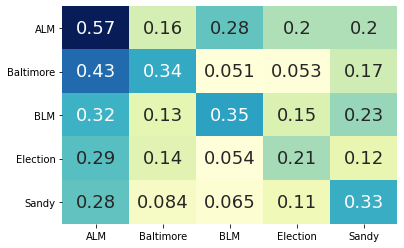

In [84]:
sns.heatmap(domain_perform_df, annot=True, cmap="YlGnBu", annot_kws={"size": 18}, cbar=False)

In [86]:
perform_df = pd.DataFrame({'ALM': domain_perform['ALM']})
print(perform_df)

                ALM
ALM        0.572216
BLM        0.318759
Baltimore  0.426079
Election   0.288816
Sandy      0.278053


<AxesSubplot:>

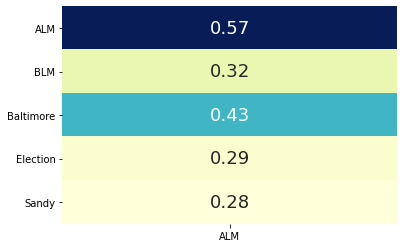

In [87]:
sns.heatmap(perform_df, annot=True, cmap="YlGnBu", annot_kws={"size": 18}, cbar=False)

In [89]:
unique_labels = set()
for idx, row in all_data.iterrows():
    for label in str(row.labels).split(','):
        unique_labels.add(label)
unique_labels = list(unique_labels)
print(unique_labels)

['care', 'harm', 'betrayal', 'authority', 'subversion', 'loyalty', 'purity', 'non-moral', 'cheating', 'fairness', 'degradation']


In [90]:
def label_encoder(raw_label):
    all_labels = [
        'subversion', 'loyalty', 'care', 'cheating',
        'purity', 'fairness', 'degradation', 'betrayal', 'harm', 'authority'
    ]
    encode_label = [0]*len(all_labels)
    if type(raw_label) != str:
        encode_label[-1] = 1
        return encode_label
    for label in raw_label.split(','):
        if label not in all_labels:
            encode_label[-1] = 1
        else:
            encode_label[all_labels.index(label)] = 1
    return encode_label

In [91]:
def micro_f1_average(y_preds, y_truths):
    precisions = []
    recalls = []
    for idx, (y_pred, y_truth) in enumerate(zip(y_preds, y_truths)):
        true_positives = np.sum(np.logical_and(y_truth, y_pred))

        # compute the sum of tp + fp across training examples and labels
        l_prec_den = np.sum(y_pred)
        if l_prec_den != 0:
            # compute micro-averaged precision
            precisions.append(true_positives/l_prec_den)
        
        # compute sum of tp + fn across training examples and labels
        l_recall_den = np.sum(y_truth)

        # compute mirco-average recall
        if l_recall_den != 0:
            recalls.append(true_positives/l_recall_den)

    precisions = np.mean(precisions)
    recalls = np.mean(recalls)
    if precisions + recalls == 0:
        return 0
    f1 = 2*precisions*recalls / (precisions + recalls)
    return f1

In [93]:
# test in-domain and out-domain classification performance
# first split each corpus into train and test indices
domain_corpus = {}
for domain in tqdm(all_data.corpus.unique()):
    domain_df = all_data[all_data.corpus == domain]
    domain_df.labels = domain_df.labels.apply(lambda raw_label: label_encoder(raw_label))
    docs = [str(item) for item in domain_df.text]
    labels = domain_df.labels.tolist()
    
    x_train, x_test, y_train, y_test = train_test_split(
        docs, labels, test_size=0.2, random_state=33)
    domain_corpus[domain] = {}
    domain_corpus[domain]['x_test'] = x_test
    domain_corpus[domain]['y_test'] = y_test
    domain_corpus[domain]['vect'] = TfidfVectorizer(
        ngram_range=(1, 3), min_df=2, max_features=15000,
        max_df=0.9, # stop_words=spw_set, 
    )
    domain_corpus[domain]['x_train'] = x_train
    domain_corpus[domain]['y_train'] = y_train
    domain_corpus[domain]['vect'].fit(docs)
    domain_corpus[domain]['clf'] = OneVsRestClassifier(
        LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1),
        n_jobs=-1
    )
    domain_corpus[domain]['clf'].fit(domain_corpus[domain]['vect'].transform(x_train), y_train)

domain_perform = {}
for domain_i in tqdm(domain_corpus):
    if domain_i in ['Davidson', 'MeToo']:
        continue
    if domain_i not in domain_perform:
        domain_perform[domain_i] = {}
    for domain_j in domain_corpus:
        if domain_j in ['Davidson', 'MeToo']:
            continue
        y_preds = domain_corpus[domain_i]['clf'].predict(
            domain_corpus[domain_i]['vect'].transform(domain_corpus[domain_j]['x_test']))
        domain_perform[domain_i][domain_j] = micro_f1_average(
            y_preds=y_preds, y_truths=domain_corpus[domain_j]['y_test']
        )
domain_perform_df = pd.DataFrame(domain_perform)
print(domain_perform_df)

100%|██████████| 7/7 [00:00<00:00,  7.85it/s]

                ALM  Baltimore       BLM  Election     Sandy
ALM        0.748951   0.371681  0.671768  0.591999  0.523930
Baltimore  0.512882   0.751485  0.580640  0.621632  0.180067
BLM        0.740581   0.435614  0.828921  0.666858  0.546318
Election   0.508041   0.518932  0.568484  0.730022  0.305976
Sandy      0.446250   0.246373  0.416275  0.402380  0.664212


<AxesSubplot:>

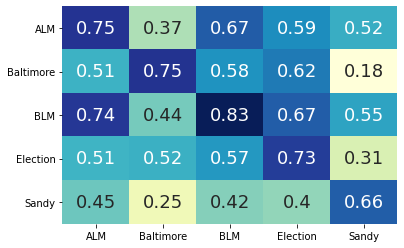

In [94]:
sns.heatmap(domain_perform_df, annot=True, cmap="YlGnBu", annot_kws={"size": 18}, cbar=False)

In [100]:
# load the vaccine data and test the classifier on the vaccine data
vaccine_df = pd.read_csv('../data/vaccine_morality.csv', dtype=str)
vaccine_df.text = vaccine_df.text.apply(lambda x: preprocess(x))
# vaccine_df = vaccine_df[vaccine_df.text.apply(lambda x: len(x) > 3)]
vaccine_df.text = vaccine_df.text.apply(lambda x: ' '.join(x))
print(len(vaccine_df))

500


In [101]:
vaccine_df.head(5)

,tweet_id,text,relatedness,intention,subversion,authority,cheating,fairness,harm,care,betrayal,loyalty,purity,degradation,non-moral,user_id,date,location
0,1.343310e+18,why would we need an immunity passport to fly ...,1,1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.491404e+09,Sun Dec 27 21:21:56 +0000 2020,"United States,Georgia,x"
1,1.385580e+18,my neck been hurting since i got the covid vac...,1,1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.326440e+18,Fri Apr 23 13:15:29 +0000 2021,"United States,District of Columbia,Washington"
2,1.289320e+18,a #covid19 vaccine willl be appreciated in aug...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.161630e+18,Fri Jul 31 22:06:58 +0000 2020,"United States,x,x"
3,1.382370e+18,@millerstrib holding back everyone until we co...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.528039e+08,Wed Apr 14 16:11:05 +0000 2021,"United States,Missouri,Kansas City"
4,1.334920e+18,i ’ ve done drugs that i found on the ground a...,1,1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,5.682487e+07,Fri Dec 04 17:42:36 +0000 2020,"United States,Michigan,Grand Rapids"


In [ ]:
# ['subversion', 'loyalty', 'care', 'cheating', 'nan', 'purity', 'fairness', 'non-moral', 
# 'degradation', 'betrayal', 'harm', 'authority']

In [102]:
vaccine_data = {
    'train_x': [],
    'train_y': [],
}

all_labels = [
    'subversion', 'loyalty', 'care', 'cheating',
    'purity', 'fairness', 'degradation', 'betrayal', 'harm', 'authority'
]

for idx, row in vaccine_df.iterrows():
    encode_label = [0] * len(all_labels)
    for label_index, label in enumerate(all_labels):
        if np.isnan(np.array(row[all_labels[label_index]], dtype=np.float32)):
            continue
        if int(row[all_labels[label_index]]) == 1:
            encode_label[label_index] = 1
    if sum(encode_label) == 0:
        encode_label[-1] = 1
    vaccine_data['train_x'].append(row['text'])
    vaccine_data['train_y'].append(encode_label)

In [103]:
print(vaccine_data['train_x'][:5])
print(vaccine_data['train_y'][:5])

['why would we need an immunity passport to fly proving we had a covid vaccine when anyone who wanted has been flying for months ?', 'my neck been hurting since i got the covid vaccine 😭 wtf', 'a #covid19 vaccine willl be appreciated in august 🙏 🏻 😪 😢 🥺 😩 😚', "@millerstrib holding back everyone until we confirm it's covid or vaccine sideeffects before the dunking begins URL", 'i ’ ve done drugs that i found on the ground at a la dispute concert so no i ’ m not worried about what ’ s in the covid vaccine .']
[[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]]


In [105]:
# test on vaccine
for domain_i in tqdm(domain_corpus):
    if domain_i in ['Davidson', 'MeToo']:
        continue
    y_preds = domain_corpus[domain_i]['clf'].predict(
        domain_corpus[domain_i]['vect'].transform(vaccine_data['train_x']))
    domain_perform[domain_i]['vaccine'] = micro_f1_average(
        y_preds=y_preds, y_truths=vaccine_data['train_y']
    )
domain_perform_df = pd.DataFrame(domain_perform)
print(domain_perform_df)

100%|██████████| 7/7 [00:00<00:00, 65.79it/s]

                ALM  Baltimore       BLM  Election     Sandy
ALM        0.748951   0.371681  0.671768  0.591999  0.523930
Baltimore  0.512882   0.751485  0.580640  0.621632  0.180067
BLM        0.740581   0.435614  0.828921  0.666858  0.546318
Election   0.508041   0.518932  0.568484  0.730022  0.305976
Sandy      0.446250   0.246373  0.416275  0.402380  0.664212
vaccine    0.033911   0.010317  0.031577  0.022671  0.126245


<AxesSubplot:>

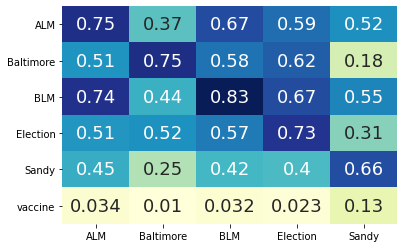

In [106]:
sns.heatmap(domain_perform_df, annot=True, cmap="YlGnBu", annot_kws={"size": 18}, cbar=False)

In [108]:
# continuous training
for domain in tqdm(all_data.corpus.unique()):
    domain_corpus[domain]['clf'].fit(
        domain_corpus[domain]['vect'].transform(
            domain_corpus[domain]['x_train'] + vaccine_data['train_x'][:100]
        ), domain_corpus[domain]['y_train'] + vaccine_data['train_y'][:100])
    
    if domain_i in ['Davidson', 'MeToo']:
        continue
    y_preds = domain_corpus[domain_i]['clf'].predict(
        domain_corpus[domain_i]['vect'].transform(vaccine_data['train_x'][100:]))
    domain_perform[domain_i]['vaccine'] = micro_f1_average(
        y_preds=y_preds, y_truths=vaccine_data['train_y'][100:]
    )
domain_perform_df = pd.DataFrame(domain_perform)
print(domain_perform_df)

100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                ALM  Baltimore       BLM  Election     Sandy
ALM        0.748951   0.371681  0.671768  0.591999  0.523930
Baltimore  0.512882   0.751485  0.580640  0.621632  0.180067
BLM        0.740581   0.435614  0.828921  0.666858  0.546318
Election   0.508041   0.518932  0.568484  0.730022  0.305976
Sandy      0.446250   0.246373  0.416275  0.402380  0.664212
vaccine    0.033911   0.010317  0.031577  0.022671  0.645603


In [110]:
# train all Twitter 35K documents and apply on the vaccine
all_twitter_vect = TfidfVectorizer(
    ngram_range=(1, 3), min_df=2, max_features=15000,
    max_df=0.9, # stop_words=spw_set,
)
all_twitter_vect.fit(all_data.text)
all_twitter_labels = all_data.labels.apply(lambda x: label_encoder(x)).tolist()

In [112]:
all_twitter_clf = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1),
    n_jobs=-1
)
all_twitter_clf.fit(all_twitter_vect.transform(all_data.text), all_twitter_labels)
vaccine_y_preds = all_twitter_clf.predict(all_twitter_vect.transform(vaccine_data['train_x']))
print(micro_f1_average(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y']))

0.02684359497215205


In [120]:
len(twitter_vaccine_docs)

31229

In [121]:
len(twitter_vaccine_labels)

31079

In [126]:
def multi_label_f1(y_preds, y_truths, mode='weighted'):
    preds = dict()
    truths = dict()
    for idx in range(len(y_truths)):
        for jdx in range(len(y_truths[idx])):
            if jdx not in preds:
                preds[jdx] = []
                truths[jdx] = []
            preds[jdx].append(y_preds[idx][jdx])
            truths[jdx].append(y_truths[idx][jdx])
    results = []
    for jdx in preds:
        results.append(metrics.f1_score(preds[jdx], truths[jdx], average=mode))
    return np.average(results)

In [133]:
# add few examples
# train all Twitter 35K documents and apply on the vaccine
all_twitter_vect = TfidfVectorizer(
    ngram_range=(1, 3), min_df=2, max_features=15000,
    max_df=0.9, stop_words=spw_set, 
)
twitter_vaccine_docs = all_data.text.tolist() + vaccine_data['train_x'][:250]
all_twitter_vect.fit(twitter_vaccine_docs)
twitter_vaccine_labels = all_data.labels.apply(lambda x: label_encoder(x)).tolist() + vaccine_data['train_y'][:250]

all_twitter_clf = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1),
    n_jobs=-1
)
all_twitter_clf.fit(all_twitter_vect.transform(twitter_vaccine_docs), twitter_vaccine_labels)
vaccine_y_preds = all_twitter_clf.predict(all_twitter_vect.transform(vaccine_data['train_x'][250:]))
print(micro_f1_average(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:]))

0.8000693355344614


In [138]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='macro')

0.6502597302923827

In [137]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='weighted')

0.9164315397446553

In [136]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='micro')

0.913090909090909

In [139]:
# only 100 --> 400 tweets
vaccine_vect = TfidfVectorizer(
    ngram_range=(1, 3), min_df=2, max_features=15000,
    max_df=0.9, stop_words=spw_set, 
)
vaccine_vect.fit(vaccine_data['train_x'])
vaccine_clf = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1),
    n_jobs=-1
)
vaccine_clf.fit(vaccine_vect.transform(vaccine_data['train_x'][:250]), vaccine_data['train_y'][:250])
vaccine_y_preds = vaccine_clf.predict(vaccine_vect.transform(vaccine_data['train_x'][250:]))
print(micro_f1_average(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:]))

0.8352740481286891


In [141]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='weighted')

0.9530376721671562

In [140]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='micro')

0.9385454545454546

In [132]:
multi_label_f1(y_preds=vaccine_y_preds, y_truths=vaccine_data['train_y'][250:], mode='macro')

0.7345658388983214

In [ ]:
with open